In [18]:
import numpy as np
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import OneHotEncoder

np.random.seed(74)

In [19]:

main_dir = "/kaggle/input/rice-leaf-disease-image"
class_names = os.listdir(main_dir)

X=[]
y=[]

for class_name in class_names:
    class_dir = os.path.join(main_dir, class_name)
    for image_file in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_file)
        image = cv2.imread(image_path)
        if image is not None:
            image = cv2.resize(image, (224, 224))
            X.append(image)
            y.append(class_name)

In [20]:
def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)
    X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.3, random_state=7)

    print('X_train = ',np.shape(X_train))
    print('y_train = ',np.shape(y_train))
    print('X_test = ',np.shape(X_test))
    print('y_test = ',np.shape(y_test))
    print('X_valid = ',np.shape(X_valid))
    print('y_valid = ',np.shape(y_valid))

    return X_train, X_test, X_valid, y_train, y_test, y_valid

X_train, X_test, X_valid, y_train, y_test, y_valid = split_data(X,y)

X_train =  (4152, 224, 224, 3)
y_train =  (4152,)
X_test =  (1246, 224, 224, 3)
y_test =  (1246,)
X_valid =  (534, 224, 224, 3)
y_valid =  (534,)


In [21]:
from collections import Counter

Counter(y_train)

Counter({'Brownspot': 1133,
         'Bacterialblight': 1101,
         'Blast': 1008,
         'Tungro': 910})

In [22]:
# datagen = ImageDataGenerator(
#     rotation_range=15,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     vertical_flip=True
# )
# augmented_images = []
# augmented_labels = []
# for image, label in zip(X_train, y_train):
#     i = 0
#     for batch in datagen.flow(tf.expand_dims(image, axis=0), batch_size=1):
#         augmented_image = tf.squeeze(batch, axis=0)
#         augmented_images.append(augmented_image)
#         augmented_labels.append(label)
#         i += 1
#         if i >= 2:
#             break

# # Convert the augmented images to a numpy array
# images = np.array(augmented_images)
# labels = np.array(augmented_labels)

In [23]:
encoder = OneHotEncoder()

y_train = encoder.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_test = encoder.transform(np.array(y_test).reshape(-1, 1)).toarray()
y_valid = encoder.transform(np.array(y_valid).reshape(-1, 1)).toarray()


In [24]:
print('X_train = ',np.shape(y_train))
print('y_train = ',np.shape(y_train))
print('X_test = ',np.shape(X_test))
print('y_test = ',np.shape(y_test))
print('X_valid = ',np.shape(X_valid))
print('y_valid = ',np.shape(y_valid))

X_train =  (4152, 4)
y_train =  (4152, 4)
X_test =  (1246, 224, 224, 3)
y_test =  (1246, 4)
X_valid =  (534, 224, 224, 3)
y_valid =  (534, 4)


In [25]:
from keras.applications.xception import preprocess_input

X_train = preprocess_input(np.array(X_train))
X_test = preprocess_input(np.array(X_test))
X_valid = preprocess_input(np.array(X_valid))

In [26]:
from keras.applications import Xception
from keras.layers import Dense, GlobalAveragePooling2D, Flatten
from keras import Sequential
from keras.models import Model



In [35]:
xception = Xception(weights='imagenet', include_top=False)
for layer in xception.layers[:-50]:
    layer.trainable = False

x = xception.output
x = GlobalAveragePooling2D()(x)  # Add this line
# x = Dense(1024, activation="relu")(x)
# x = Dense(512, activation="relu")(x)
x = Dense(256, activation="relu")(x)
x = Dense(64, activation="relu")(x)

predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=xception.input, outputs=predictions)
#model.summary()

In [36]:
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='auto',restore_best_weights=True)

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [37]:
np.shape(X_train),np.shape(y_train)

((4152, 224, 224, 3), (4152, 4))

In [38]:
model.fit(X_train, y_train, batch_size=32, epochs=14, verbose=1, validation_data=(X_valid, y_valid),callbacks=[early_stopping])

Epoch 1/14
130/130 [==============================] - 32s 151ms/step - loss: 0.2331 - accuracy: 0.9234 - val_loss: 0.5428 - val_accuracy: 0.9307
Epoch 2/14
130/130 [==============================] - 18s 137ms/step - loss: 0.0649 - accuracy: 0.9868 - val_loss: 0.0103 - val_accuracy: 1.0000
Epoch 3/14
130/130 [==============================] - 18s 136ms/step - loss: 0.0433 - accuracy: 0.9904 - val_loss: 1.0952 - val_accuracy: 0.8914
Epoch 4/14
130/130 [==============================] - 18s 137ms/step - loss: 0.0782 - accuracy: 0.9841 - val_loss: 0.0037 - val_accuracy: 0.9981
Epoch 5/14
130/130 [==============================] - 18s 136ms/step - loss: 0.0362 - accuracy: 0.9925 - val_loss: 5.9703e-04 - val_accuracy: 1.0000
Epoch 6/14
130/130 [==============================] - 18s 136ms/step - loss: 0.0341 - accuracy: 0.9918 - val_loss: 0.8952 - val_accuracy: 0.9700
Epoch 7/14
130/130 [==============================] - 18s 136ms/step - loss: 0.0213 - accuracy: 0.9961 - val_loss: 0.0026 - va

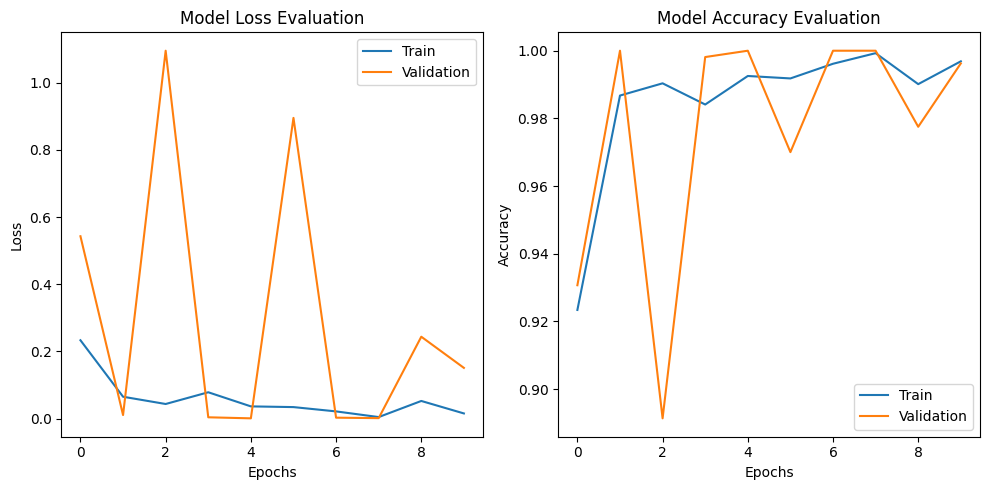

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss Evaluation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model Accuracy Evaluation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()


In [40]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.014176466502249241
Test accuracy: 0.9959871768951416


In [41]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

39/39 [==============================] - 4s 73ms/step


In [42]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=class_names))

                 precision    recall  f1-score   support

         Tungro       0.99      1.00      1.00       333
Bacterialblight       1.00      0.99      0.99       321
          Blast       1.00      1.00      1.00       332
      Brownspot       0.99      1.00      0.99       260

       accuracy                           1.00      1246
      macro avg       1.00      1.00      1.00      1246
   weighted avg       1.00      1.00      1.00      1246



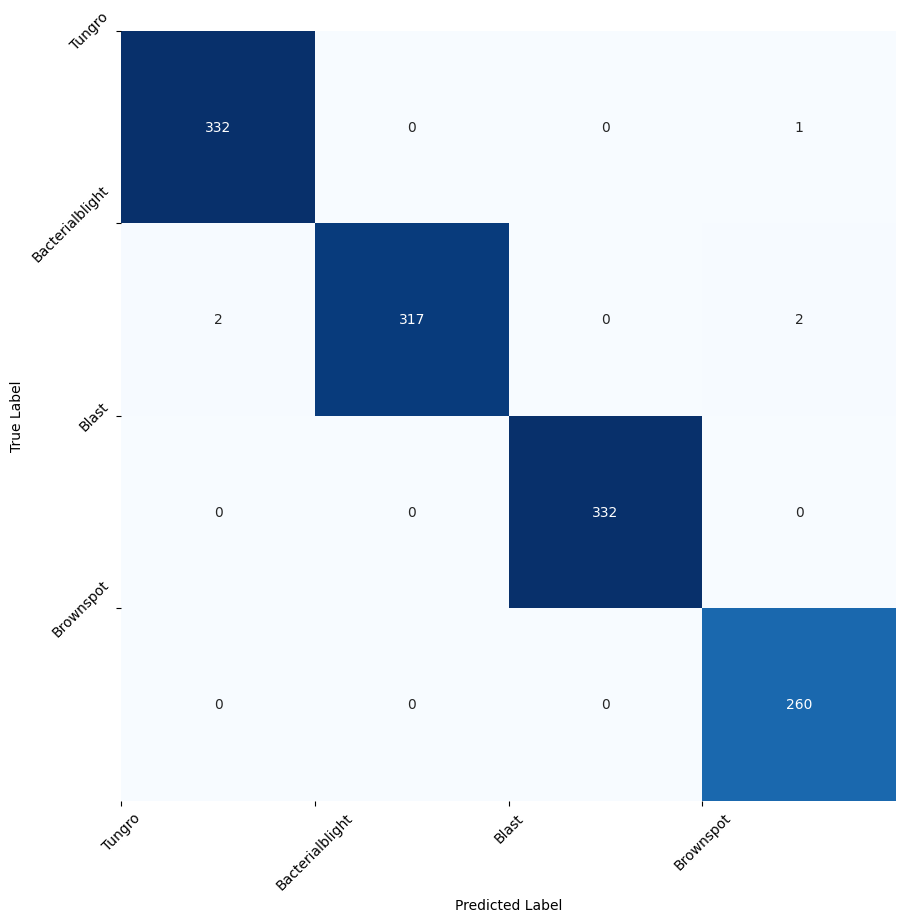

In [43]:
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)

plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names, rotation=45)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [44]:
model.save('model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
classification_report for classify Rice Leaf Disease Image

                 precision    recall  f1-score   support

         Tungro       0.99      1.00      1.00       333
Bacterialblight       1.00      0.99      0.99       321
          Blast       1.00      1.00      1.00       332
      Brownspot       0.99      1.00      0.99       260

       accuracy                           1.00      1246
      macro avg       1.00      1.00      1.00      1246
   weighted avg       1.00      1.00      1.00      1246

